In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [31]:
# datasets
labels = pd.read_csv("/kaggle/input/analytics-vidya-ripik-ai-hackfest/train/train/train.csv")
sample = pd.read_csv('/kaggle/input/analytics-vidya-ripik-ai-hackfest/sample_submission-3.csv')

# folders paths
train_path = "/kaggle/input/analytics-vidya-ripik-ai-hackfest/train/train/images"
test_path = "/kaggle/input/analytics-vidya-ripik-ai-hackfest/test/test/images"
test = pd.read_csv("/kaggle/input/analytics-vidya-ripik-ai-hackfest/test/test/test.csv")

In [32]:
labels.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [33]:
labels['label'] = labels['label'].replace({
    1: 'crack',
    2: 'scratch',
    3: 'tire flat',
    4: 'dent',
    5: 'glass shatter',
    6: 'lamp broken'
})

In [34]:
labels

,image_id,filename,label
0,1,1.jpg,scratch
1,2,2.jpg,dent
2,3,3.jpg,scratch
3,4,4.jpg,tire flat
4,5,5.jpg,glass shatter
...,...,...,...
7195,7196,7196.jpg,dent
7196,7197,7197.jpg,dent
7197,7198,7198.jpg,dent
7198,7199,7199.jpg,scratch


In [35]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder
label_encoder = LabelEncoder()

# Encode the labels
encoded_labels = label_encoder.fit_transform(labels['label'])

In [36]:
encoded_labels,labels.label

(array([4, 1, 4, ..., 1, 4, 4]),
 0             scratch
 1                dent
 2             scratch
 3           tire flat
 4       glass shatter
             ...      
 7195             dent
 7196             dent
 7197             dent
 7198          scratch
 7199          scratch
 Name: label, Length: 7200, dtype: object)

In [37]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale=1./255.,
                         horizontal_flip = True,
                         validation_split=0.2 # training: 80% data, validation: 20% data
                        )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)


Found 5760 validated image filenames belonging to 6 classes.
Found 1440 validated image filenames belonging to 6 classes.


In [38]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

In [52]:
X_val,y_val=next(validation_generator)


AttributeError: 'numpy.ndarray' object has no attribute 'shpe'

In [54]:
X_val.shape,y.shape

((32, 331, 331, 3), (32, 6))

In [39]:
dir(train_generator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_params',
 '_filepaths',
 '_filter_classes',
 '_filter_valid_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_sample_weight',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'get_classes',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'keep_aspect_ratio',
 'labels',
 'lock',
 'n',
 'next',
 'o

In [40]:
train_generator.class_indices

{'crack': 0,
 'dent': 1,
 'glass shatter': 2,
 'lamp broken': 3,
 'scratch': 4,
 'tire flat': 5}

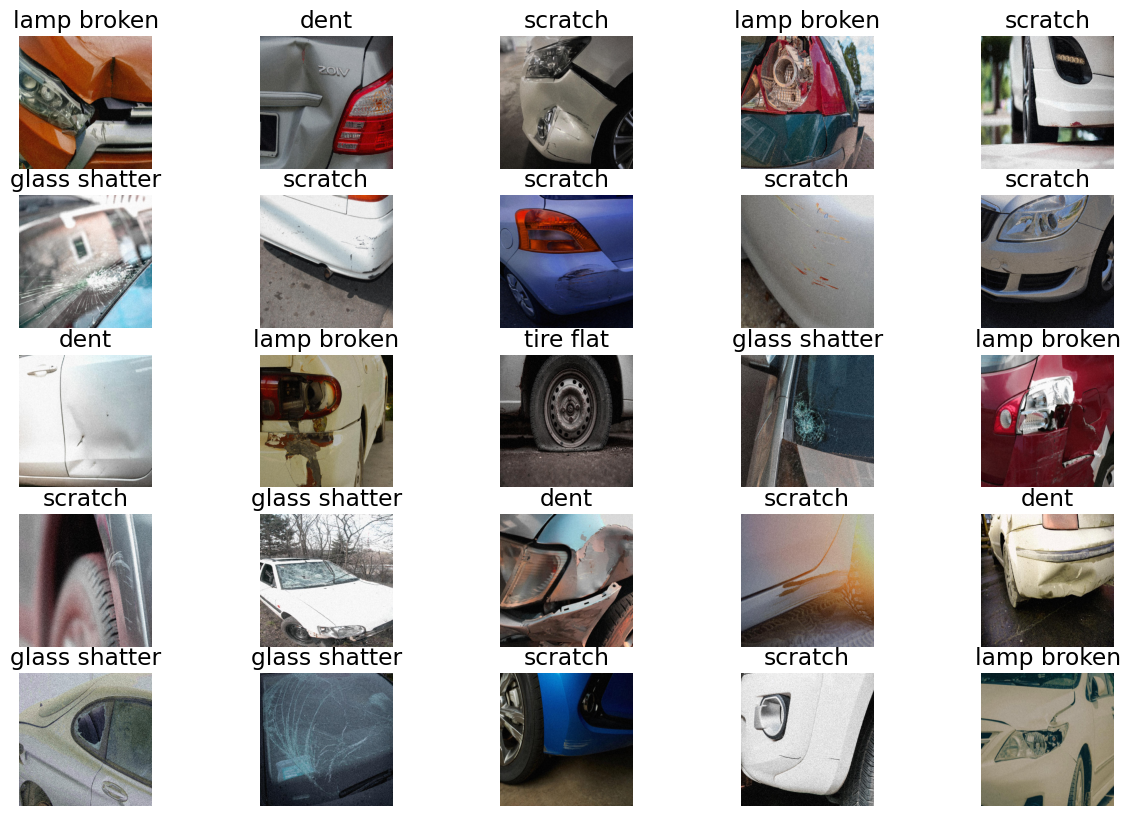

In [41]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [42]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                     weights='imagenet',
                                                     input_shape=(331,331,3))

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([base_model, 
                             tf.keras.layers.BatchNormalization(renorm=True),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(6, activation='softmax')])

In [43]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_407 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

In [45]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                         min_delta=0.001,
                                         restore_best_weights=True)
# early stopping call back

In [60]:
batch_size=64
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=[early])


Epoch 1/30
180/180 [==============================] - 76s 420ms/step - loss: 0.7698 - accuracy: 0.7012 - val_loss: 0.6274 - val_accuracy: 0.7556
Epoch 2/30
180/180 [==============================] - 75s 417ms/step - loss: 0.5533 - accuracy: 0.7913 - val_loss: 0.4767 - val_accuracy: 0.8181
Epoch 3/30
180/180 [==============================] - 73s 404ms/step - loss: 0.3956 - accuracy: 0.8491 - val_loss: 0.3679 - val_accuracy: 0.8549
Epoch 4/30
180/180 [==============================] - 73s 404ms/step - loss: 0.3015 - accuracy: 0.8875 - val_loss: 0.3644 - val_accuracy: 0.8806
Epoch 5/30
180/180 [==============================] - 72s 399ms/step - loss: 0.2164 - accuracy: 0.9231 - val_loss: 0.2516 - val_accuracy: 0.9049
Epoch 6/30
180/180 [==============================] - 73s 403ms/step - loss: 0.1679 - accuracy: 0.9427 - val_loss: 0.2322 - val_accuracy: 0.9201
Epoch 7/30
180/180 [==============================] - 72s 398ms/step - loss: 0.1244 - accuracy: 0.9557 - val_loss: 0.3064 - val_ac

In [62]:
model.save("/kaggle/working/Model_IncpV2.h5")

In [63]:
# # Load the trained model
# model_path = '/kaggle/working/Model.h5'
# model = load_model(model_path)

In [58]:
# from keras.models import load_model
# model = load_model('Model.h5')

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9927083253860474\nValidation Accuracy: 0.9583333134651184')

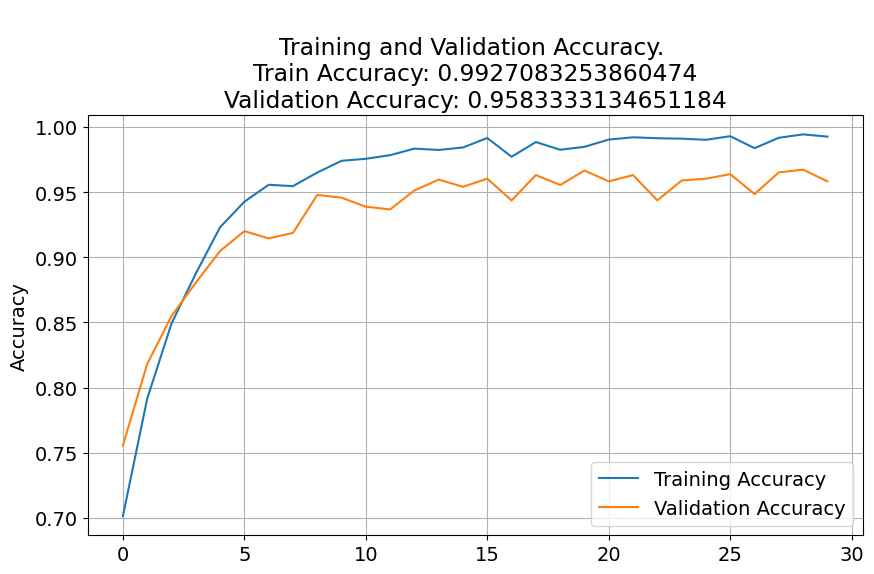

In [64]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# plot results
# accuracy
plt.figure(figsize=(10, 12))
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

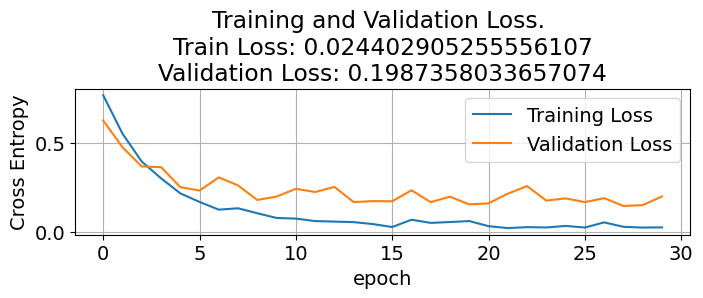

In [65]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [66]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

45/45 [==============================] - 15s 324ms/step - loss: 0.1776 - accuracy: 0.9604
[0.17764021456241608, 0.9604166746139526]
Accuracy: 96.0417%
Loss:  0.17764021456241608


In [68]:
y_val

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0.

In [67]:
from sklearn.metrics import classification_report

# Assuming model.predict_classes() gives the predicted labels for X_val
# predicted_labels = model.predict(X_val)
predicted_probs = model.predict(X_val)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Generate the classification report
report = classification_report(y_val, predicted_labels)

# Print the classification report
print("Classification Report:\n", report)

1/1 [==============================] - 0s 99ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

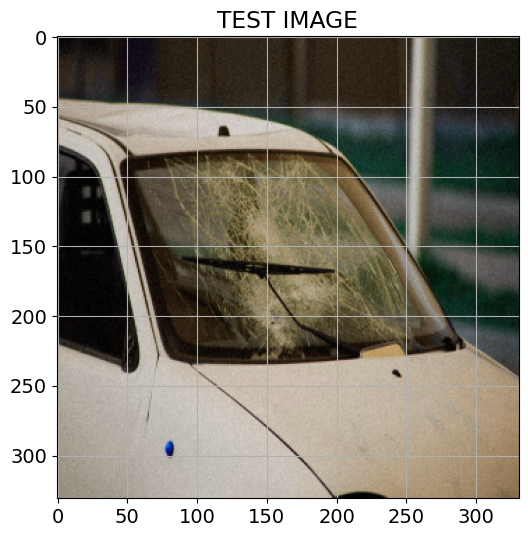

In [69]:
test_img_path = test_path+"/7204.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [70]:
label_to_number = {
    'crack': 1,
    'scratch': 2,
    'tire flat': 3,
    'dent': 4,
    'glass shatter': 5,
    'lamp broken': 6
}

In [73]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

# Assuming you have a DataFrame named 'sample' with an 'image_id' column
# containing the filenames of the test images

# Set up paths and other parameters
# test_path = "/path/to/test/images"
batch_size = 32  # Adjust according to your needs

# Create an ImageDataGenerator for preprocessing images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

# Create a list to store predictions
predictions_list = []

# Iterate through batches of images with tqdm for a progress bar
for batch_start in tqdm(range(0, len(sample), batch_size)):
    batch_end = min(batch_start + batch_size, len(sample))
    batch_image_ids = sample.iloc[batch_start:batch_end]['image_id'].tolist()

    # Load and preprocess batch of images
    batch_images = []
    for image_id in batch_image_ids:
        img_path = f"{test_path}/{image_id}.jpg"
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(331, 331))
        img = tf.keras.preprocessing.image.img_to_array(img)
        batch_images.append(img)

    # Convert the batch to a NumPy array
    batch_images = np.array(batch_images) / 255.0  # Normalize pixel values

    # Make predictions for the batch
    batch_predictions = model.predict(batch_images)

    # Extract predicted labels and map them back to numbers
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    batch_predicted_numbers = [label_to_number[class_names[label]] for label in batch_predicted_labels]

    # Append predictions to the list
    predictions_list.extend(list(zip(batch_image_ids, batch_predicted_numbers)))

# Create a DataFrame from the list of predictions
predictions_df = pd.DataFrame(predictions_list, columns=['image_id', 'predicted_number'])

# Print or save predictions
print(predictions_df)


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


  1%|          | 1/150 [00:00<01:35,  1.56it/s]

1/1 [==============================] - 0s 101ms/step


  1%|▏         | 2/150 [00:01<01:31,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


  2%|▏         | 3/150 [00:01<01:31,  1.60it/s]

1/1 [==============================] - 0s 102ms/step


  3%|▎         | 4/150 [00:02<01:29,  1.62it/s]

1/1 [==============================] - 0s 102ms/step


  3%|▎         | 5/150 [00:03<01:29,  1.62it/s]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 6/150 [00:03<01:28,  1.63it/s]

1/1 [==============================] - 0s 103ms/step


  5%|▍         | 7/150 [00:04<01:28,  1.62it/s]

1/1 [==============================] - 0s 101ms/step


  5%|▌         | 8/150 [00:04<01:29,  1.60it/s]

1/1 [==============================] - 0s 106ms/step


  6%|▌         | 9/150 [00:05<01:28,  1.60it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 10/150 [00:06<01:27,  1.59it/s]

1/1 [==============================] - 0s 105ms/step


  7%|▋         | 11/150 [00:06<01:25,  1.63it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 12/150 [00:07<01:25,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▊         | 13/150 [00:08<01:24,  1.62it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 14/150 [00:08<01:23,  1.62it/s]

1/1 [==============================] - 0s 102ms/step


 10%|█         | 15/150 [00:09<01:22,  1.63it/s]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 16/150 [00:09<01:22,  1.63it/s]

1/1 [==============================] - 0s 100ms/step


 11%|█▏        | 17/150 [00:10<01:19,  1.66it/s]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 18/150 [00:11<01:20,  1.65it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 19/150 [00:11<01:19,  1.65it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 20/150 [00:12<01:19,  1.63it/s]

1/1 [==============================] - 0s 106ms/step


 14%|█▍        | 21/150 [00:12<01:18,  1.63it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█▍        | 22/150 [00:13<01:19,  1.61it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█▌        | 23/150 [00:14<01:19,  1.60it/s]

1/1 [==============================] - 0s 101ms/step


 16%|█▌        | 24/150 [00:14<01:18,  1.60it/s]

1/1 [==============================] - 0s 100ms/step


 17%|█▋        | 25/150 [00:15<01:16,  1.62it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█▋        | 26/150 [00:16<01:15,  1.63it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 27/150 [00:16<01:14,  1.64it/s]

1/1 [==============================] - 0s 103ms/step


 19%|█▊        | 28/150 [00:17<01:15,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 29/150 [00:17<01:13,  1.64it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 30/150 [00:18<01:13,  1.64it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 31/150 [00:19<01:11,  1.65it/s]

1/1 [==============================] - 0s 100ms/step


 21%|██▏       | 32/150 [00:19<01:13,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 33/150 [00:20<01:11,  1.63it/s]

1/1 [==============================] - 0s 101ms/step


 23%|██▎       | 34/150 [00:20<01:11,  1.63it/s]

1/1 [==============================] - 0s 98ms/step


 23%|██▎       | 35/150 [00:21<01:10,  1.63it/s]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 36/150 [00:22<01:10,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


 25%|██▍       | 37/150 [00:22<01:10,  1.60it/s]

1/1 [==============================] - 0s 101ms/step


 25%|██▌       | 38/150 [00:23<01:08,  1.63it/s]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 39/150 [00:24<01:07,  1.64it/s]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 40/150 [00:24<01:07,  1.64it/s]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 41/150 [00:25<01:05,  1.67it/s]

1/1 [==============================] - 0s 110ms/step


 28%|██▊       | 42/150 [00:25<01:05,  1.64it/s]

1/1 [==============================] - 0s 102ms/step


 29%|██▊       | 43/150 [00:26<01:05,  1.64it/s]

1/1 [==============================] - 0s 100ms/step


 29%|██▉       | 44/150 [00:27<01:04,  1.64it/s]

1/1 [==============================] - 0s 102ms/step


 30%|███       | 45/150 [00:27<01:03,  1.64it/s]

1/1 [==============================] - 0s 101ms/step


 31%|███       | 46/150 [00:28<01:02,  1.65it/s]

1/1 [==============================] - 0s 102ms/step


 31%|███▏      | 47/150 [00:28<01:02,  1.64it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 48/150 [00:29<01:02,  1.63it/s]

1/1 [==============================] - 0s 101ms/step


 33%|███▎      | 49/150 [00:30<01:01,  1.63it/s]

1/1 [==============================] - 0s 101ms/step


 33%|███▎      | 50/150 [00:30<01:00,  1.65it/s]

1/1 [==============================] - 0s 101ms/step


 34%|███▍      | 51/150 [00:31<00:59,  1.66it/s]

1/1 [==============================] - 0s 100ms/step


 35%|███▍      | 52/150 [00:31<00:59,  1.65it/s]

1/1 [==============================] - 0s 101ms/step


 35%|███▌      | 53/150 [00:32<00:58,  1.67it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▌      | 54/150 [00:33<00:57,  1.66it/s]

1/1 [==============================] - 0s 102ms/step


 37%|███▋      | 55/150 [00:33<00:57,  1.65it/s]

1/1 [==============================] - 0s 102ms/step


 37%|███▋      | 56/150 [00:34<00:58,  1.62it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 57/150 [00:34<00:57,  1.61it/s]

1/1 [==============================] - 0s 103ms/step


 39%|███▊      | 58/150 [00:35<00:57,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


 39%|███▉      | 59/150 [00:36<00:56,  1.60it/s]

1/1 [==============================] - 0s 103ms/step


 40%|████      | 60/150 [00:36<00:56,  1.59it/s]

1/1 [==============================] - 0s 107ms/step


 41%|████      | 61/150 [00:37<00:56,  1.57it/s]

1/1 [==============================] - 0s 102ms/step


 41%|████▏     | 62/150 [00:38<00:56,  1.56it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████▏     | 63/150 [00:38<00:56,  1.54it/s]

1/1 [==============================] - 0s 103ms/step


 43%|████▎     | 64/150 [00:39<00:54,  1.57it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████▎     | 65/150 [00:40<00:53,  1.58it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████▍     | 66/150 [00:40<00:53,  1.58it/s]

1/1 [==============================] - 0s 101ms/step


 45%|████▍     | 67/150 [00:41<00:52,  1.60it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████▌     | 68/150 [00:41<00:52,  1.57it/s]

1/1 [==============================] - 0s 102ms/step


 46%|████▌     | 69/150 [00:42<00:51,  1.58it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████▋     | 70/150 [00:43<00:50,  1.59it/s]

1/1 [==============================] - 0s 102ms/step


 47%|████▋     | 71/150 [00:43<00:50,  1.58it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 72/150 [00:44<00:49,  1.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▊     | 73/150 [00:45<00:48,  1.58it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 74/150 [00:45<00:47,  1.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|█████     | 75/150 [00:46<00:47,  1.57it/s]

1/1 [==============================] - 0s 101ms/step


 51%|█████     | 76/150 [00:47<00:47,  1.54it/s]

1/1 [==============================] - 0s 103ms/step


 51%|█████▏    | 77/150 [00:47<00:47,  1.55it/s]

1/1 [==============================] - 0s 102ms/step


 52%|█████▏    | 78/150 [00:48<00:46,  1.56it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████▎    | 79/150 [00:49<00:45,  1.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 80/150 [00:49<00:45,  1.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|█████▍    | 81/150 [00:50<00:44,  1.56it/s]

1/1 [==============================] - 0s 104ms/step


 55%|█████▍    | 82/150 [00:50<00:43,  1.57it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████▌    | 83/150 [00:51<00:42,  1.57it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████▌    | 84/150 [00:52<00:42,  1.55it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 85/150 [00:52<00:41,  1.58it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████▋    | 86/150 [00:53<00:39,  1.60it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 87/150 [00:54<00:39,  1.61it/s]

1/1 [==============================] - 0s 102ms/step


 59%|█████▊    | 88/150 [00:54<00:38,  1.60it/s]

1/1 [==============================] - 0s 102ms/step


 59%|█████▉    | 89/150 [00:55<00:38,  1.60it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████    | 90/150 [00:55<00:37,  1.61it/s]

1/1 [==============================] - 0s 101ms/step


 61%|██████    | 91/150 [00:56<00:37,  1.59it/s]

1/1 [==============================] - 0s 106ms/step


 61%|██████▏   | 92/150 [00:57<00:37,  1.55it/s]

1/1 [==============================] - 0s 100ms/step


 62%|██████▏   | 93/150 [00:57<00:36,  1.56it/s]

1/1 [==============================] - 0s 104ms/step


 63%|██████▎   | 94/150 [00:58<00:36,  1.53it/s]

1/1 [==============================] - 0s 104ms/step


 63%|██████▎   | 95/150 [00:59<00:35,  1.56it/s]

1/1 [==============================] - 0s 100ms/step


 64%|██████▍   | 96/150 [00:59<00:34,  1.58it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▍   | 97/150 [01:00<00:33,  1.57it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 98/150 [01:01<00:35,  1.45it/s]

1/1 [==============================] - 0s 103ms/step


 66%|██████▌   | 99/150 [01:02<00:40,  1.27it/s]

1/1 [==============================] - 0s 103ms/step


 67%|██████▋   | 100/150 [01:03<00:40,  1.23it/s]

1/1 [==============================] - 0s 102ms/step


 67%|██████▋   | 101/150 [01:04<00:40,  1.20it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 102/150 [01:04<00:41,  1.17it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████▊   | 103/150 [01:05<00:42,  1.11it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 104/150 [01:06<00:41,  1.11it/s]

1/1 [==============================] - 0s 108ms/step


 70%|███████   | 105/150 [01:07<00:40,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 71%|███████   | 106/150 [01:08<00:39,  1.11it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████▏  | 107/150 [01:09<00:38,  1.11it/s]

1/1 [==============================] - 0s 101ms/step


 72%|███████▏  | 108/150 [01:10<00:38,  1.10it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 109/150 [01:11<00:37,  1.11it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 110/150 [01:12<00:36,  1.11it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▍  | 111/150 [01:13<00:35,  1.10it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████▍  | 112/150 [01:14<00:34,  1.11it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████▌  | 113/150 [01:14<00:33,  1.10it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████▌  | 114/150 [01:16<00:35,  1.03it/s]

1/1 [==============================] - 0s 105ms/step


 77%|███████▋  | 115/150 [01:16<00:33,  1.05it/s]

1/1 [==============================] - 0s 102ms/step


 77%|███████▋  | 116/150 [01:17<00:31,  1.07it/s]

1/1 [==============================] - 0s 103ms/step


 78%|███████▊  | 117/150 [01:18<00:31,  1.06it/s]

1/1 [==============================] - 0s 101ms/step


 79%|███████▊  | 118/150 [01:19<00:29,  1.07it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 119/150 [01:20<00:28,  1.08it/s]

1/1 [==============================] - 0s 102ms/step


 80%|████████  | 120/150 [01:21<00:27,  1.08it/s]

1/1 [==============================] - 0s 102ms/step


 81%|████████  | 121/150 [01:22<00:26,  1.09it/s]

1/1 [==============================] - 0s 101ms/step


 81%|████████▏ | 122/150 [01:23<00:25,  1.10it/s]

1/1 [==============================] - 0s 99ms/step


 82%|████████▏ | 123/150 [01:24<00:24,  1.12it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 124/150 [01:25<00:23,  1.12it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 125/150 [01:26<00:22,  1.12it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 126/150 [01:26<00:21,  1.11it/s]

1/1 [==============================] - 0s 99ms/step


 85%|████████▍ | 127/150 [01:27<00:20,  1.13it/s]

1/1 [==============================] - 0s 109ms/step


 85%|████████▌ | 128/150 [01:28<00:19,  1.11it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 129/150 [01:29<00:18,  1.12it/s]

1/1 [==============================] - 0s 101ms/step


 87%|████████▋ | 130/150 [01:30<00:18,  1.11it/s]

1/1 [==============================] - 0s 103ms/step


 87%|████████▋ | 131/150 [01:31<00:17,  1.10it/s]

1/1 [==============================] - 0s 102ms/step


 88%|████████▊ | 132/150 [01:32<00:17,  1.05it/s]

1/1 [==============================] - 0s 100ms/step


 89%|████████▊ | 133/150 [01:33<00:15,  1.08it/s]

1/1 [==============================] - 0s 99ms/step


 89%|████████▉ | 134/150 [01:34<00:15,  1.06it/s]

1/1 [==============================] - 0s 101ms/step


 90%|█████████ | 135/150 [01:35<00:13,  1.07it/s]

1/1 [==============================] - 0s 101ms/step


 91%|█████████ | 136/150 [01:36<00:12,  1.09it/s]

1/1 [==============================] - 0s 100ms/step


 91%|█████████▏| 137/150 [01:37<00:11,  1.10it/s]

1/1 [==============================] - 0s 100ms/step


 92%|█████████▏| 138/150 [01:37<00:10,  1.11it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 139/150 [01:38<00:10,  1.10it/s]

1/1 [==============================] - 0s 100ms/step


 93%|█████████▎| 140/150 [01:39<00:09,  1.10it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▍| 141/150 [01:40<00:08,  1.10it/s]

1/1 [==============================] - 0s 99ms/step


 95%|█████████▍| 142/150 [01:41<00:07,  1.09it/s]

1/1 [==============================] - 0s 99ms/step


 95%|█████████▌| 143/150 [01:42<00:06,  1.11it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▌| 144/150 [01:43<00:05,  1.11it/s]

1/1 [==============================] - 0s 98ms/step


 97%|█████████▋| 145/150 [01:44<00:04,  1.12it/s]

1/1 [==============================] - 0s 100ms/step


 97%|█████████▋| 146/150 [01:45<00:03,  1.13it/s]

1/1 [==============================] - 0s 97ms/step


 98%|█████████▊| 147/150 [01:45<00:02,  1.13it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▊| 148/150 [01:46<00:01,  1.10it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▉| 149/150 [01:47<00:00,  1.12it/s]

1/1 [==============================] - 0s 98ms/step


100%|██████████| 150/150 [01:48<00:00,  1.38it/s]

      image_id  predicted_number
0         7201                 5
1         7202                 2
2         7203                 2
3         7204                 5
4         7205                 4
...        ...               ...
4795     11996                 6
4796     11997                 5
4797     11998                 4
4798     11999                 2
4799     12000                 4

[4800 rows x 2 columns]


In [76]:
# Select 'image_id' and 'predicted_number' columns
submission_data = predictions_df[['image_id', 'predicted_number']]

# Rename the 'predicted_number' column to 'label'
submission_data = submission_data.rename(columns={'predicted_number': 'label'})

# Save the selected columns to a CSV file
submission_data.to_csv('submission.csv', index=False)

# Print or save predictions
print(submission_data)


      image_id  label
0         7201      5
1         7202      2
2         7203      2
3         7204      5
4         7205      4
...        ...    ...
4795     11996      6
4796     11997      5
4797     11998      4
4798     11999      2
4799     12000      4

[4800 rows x 2 columns]


In [74]:
# predictions = []

# for image_id in sample.image_id:
#     img_path = f"{test_path}/{image_id}.jpg"  # Assuming the image files are named like '1.jpg', '2.jpg', etc.
    
#     img = tf.keras.preprocessing.image.load_img(img_path)
#     img = tf.keras.preprocessing.image.img_to_array(img)
#     img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
#     img = tf.reshape(img, (-1, 331, 331, 3))
    
#     prediction = model.predict(img / 255)
#     predicted_label = class_names[np.argmax(prediction)]
#     # Map the predicted label back to number
#     predicted_number = label_to_number[predicted_label]
#     predictions.append(predicted_number)

In [75]:
my_submission = pd.DataFrame({'image_id': sample.image_id, 'label': predictions})
my_submission.to_csv('submission.csv', index=False)

# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head())

ValueError: array length 1865 does not match index length 4800